In [1]:
from __future__ import print_function, division
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import pylab as pl
%pylab inline
#import urllib.request
import choroplethNYC as cp
from censusAPI import myAPI
#import urllib.request

import requests
import json
import io
import fiona
import shapely
from shapely.geometry import Point
import zipfile
try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Populating the interactive namespace from numpy and matplotlib


In [2]:
PUIDATA = os.getenv("PUIDATA")
print(PUIDATA)

/home/cusp/ep2247/PUIdata


In [3]:
# Upload PUMA data from PUIdata

pumashp = gpd.read_file(PUIDATA + "/PUMA/geo_export_28ea732f-53fa-470a-aed2-8a3023b47dc9.shp")


# Upload the data from API
url = 'https://data.cityofnewyork.us/resource/ith2-q832.json'
    
fileName = 'ith2-q832.json'

urllib.request.urlretrieve(url, fileName)



In [4]:
pumashp.head()

,puma,shape_leng,shape_area,geometry
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...


In [5]:
pumashp.crs

{'init': 'epsg:4326'}

##### 1.2

(<matplotlib.figure.Figure at 0x7fda53e15d30>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fda53e2f898>)

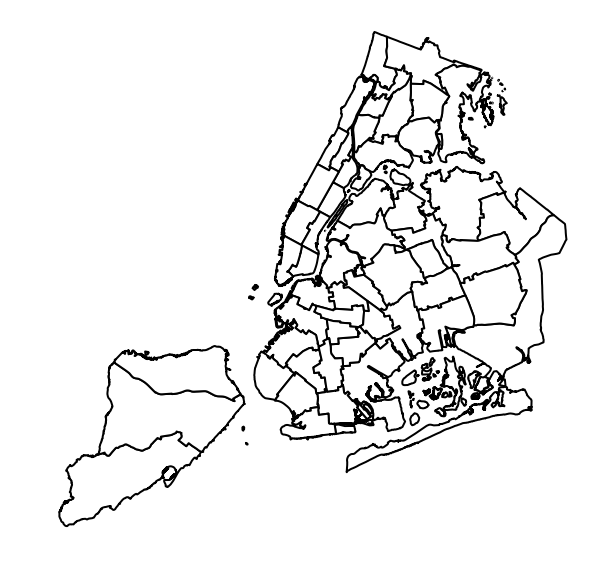

In [6]:
cp.choroplethNYC(pumashp, column = None, color = 'white', 
                 edgecolor = 'black', lw = 2)

### Figure 1: Map of NYC Public Use Microdata Areas. 

##### 2.1

In [7]:
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [8]:
affkeys = np.array(list(aff1y['variables'].keys()))

In [9]:
#extracting variables of B28002 that contain "broadband"
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") and 
 'Broadband' in aff1y['variables'][k]['label']]

[('B28002_008EA',
  'Annotation of Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_007M',
  'Margin of Error!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_008E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_004MA',
  'Annotation of Margin of Error!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_007E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_007EA',
  'Annotation of Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_004EA',
  'Annotation of Estimate!!Total!!With an Internet subscription!!Broadband of

In [10]:
#keyword for the number of households
keyNhouseholds = 'B28002_001E'
aff1y['variables'][keyNhouseholds]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

In [11]:
keyNBB = 'B28002_004E'
aff1y['variables'][keyNBB]

{'attributes': 'B28002_004M,B28002_004EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

In [12]:
print(myAPI)

c75225e2b395a47c379edc4a5fc688cc54f262a9


In [13]:
# getting the broadband access number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [14]:
# getting the total number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNhouseholds +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPP = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaPP.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


##### 2.2 generate a feature for the percentage of households with broadband access

In [15]:
pumaBB.columns

Index(['B28002_004E', 'NAME', 'state', 'public use microdata area',
       'Unnamed: 4'],
      dtype='object')

In [16]:
#drop Unnamed: 4 from pumaBB

pumaBB.drop(['Unnamed: 4'], axis = 1, inplace = True)
pumaBB.head()

,B28002_004E,NAME,state,public use microdata area
0,32607,"St. Lawrence County PUMA, New York",36,100
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200
2,41210,"Warren & Washington Counties PUMA, New York",36,300
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402


In [17]:
# drop Unnamed: 4, Name, State from pumaPP
pumaPP.drop(['NAME','state','Unnamed: 4'], axis = 1, inplace = True)
pumaPP.head()

,B28002_001E,public use microdata area
0,40479,100
1,67092,200
2,51614,300
3,44300,401
4,61146,402


In [18]:
#merge puma BB and puma PP on public use microdata area

pumaBB = pumaBB.merge(pumaPP, on = 'public use microdata area')
pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,B28002_001E
0,32607,"St. Lawrence County PUMA, New York",36,100,40479
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,67092
2,41210,"Warren & Washington Counties PUMA, New York",36,300,51614
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,44300
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,61146


In [19]:
pumaBB.columns

Index(['B28002_004E', 'NAME', 'state', 'public use microdata area',
       'B28002_001E'],
      dtype='object')

In [20]:
# create pcBB column

pumaBB['pcBB'] = (pumaBB['B28002_004E'] / pumaBB['B28002_001E']) * 100
pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,B28002_001E,pcBB
0,32607,"St. Lawrence County PUMA, New York",36,100,40479,80.552879
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,67092,75.733321
2,41210,"Warren & Washington Counties PUMA, New York",36,300,51614,79.842678
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,44300,81.433409
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,61146,78.150656


##### 2.3 Now compare it with the AFF published "percentage of households with broadband access" which is a feature available through their website but that cannot be downloaded directly from the API. It compiled by AFF the same way we did above

In [21]:
#unzip the aff downloaded file

unZip = zipfile.ZipFile(PUIDATA + '/aff_download.zip')


bbpc = pd.read_csv(PUIDATA + 
                   "/aff_download/ACS_16_1YR_GCT2801.ST50_with_ann.csv",
                   skiprows = 1,usecols=["Target Geo Id2","Percent",
                                         "Margin of Error"])

bbpc.head()

,Target Geo Id2,Percent,Margin of Error
0,1,74.7,0.5
1,100100,70.9,2.5
2,100200,80.5,2.7
3,100301,87.0,2.8
4,100302,81.9,2.9


In [22]:
bbpc.columns = ['gid', 'HC01', 'HC02']

#subtract 3600000 from each value
bbpc['gid'] = bbpc['gid']-3600000
bbpc.head()

,gid,HC01,HC02
0,-3599999,74.7,0.5
1,-3499900,70.9,2.5
2,-3499800,80.5,2.7
3,-3499699,87.0,2.8
4,-3499698,81.9,2.9


In [23]:
diff_ = pumaBB.merge(bbpc, right_on="gid", 
                     left_on="public use microdata area")[["pcBB", "HC01"]]

diff_["diff"] = np.abs(diff_["pcBB"] - diff_["HC01"].astype(float))

diff_.describe()

,pcBB,HC01,diff
count,145.000000,145.000000,145.000000
mean,81.845478,81.843448,0.026217
std,7.063369,7.065358,0.014480
min,54.932945,54.900000,0.000178
25%,77.770257,77.800000,0.012252
50%,82.826141,82.800000,0.027230
75%,87.305077,87.300000,0.039090
max,93.404143,93.400000,0.049872


### 3 Plot a choropleth of NYC broadband access

##### 3.1 Merge with the puma geodataframe and plot a choropleth of the percentage of households with broadband access

In [24]:
pumashp['puma'] = pumashp['puma'].astype(int)
type(pumashp['puma'][0])

numpy.int64

In [25]:
pumashp.head()

,puma,shape_leng,shape_area,geometry
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...


In [26]:
pumaBBshp = pumashp.merge(pumaBB, left_on = 'puma', 
                          right_on = 'public use microdata area')
pumaBBshp.head()

,puma,shape_leng,shape_area,geometry,B28002_004E,NAME,state,public use microdata area,B28002_001E,pcBB
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,42158,84.275820
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...,34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,49817,68.310015
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,44329,82.826141
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,44476,72.553737
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...,40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,58706,69.425612


Text(0.5,1,'Percentage of Households with Broadband Access in NYC')

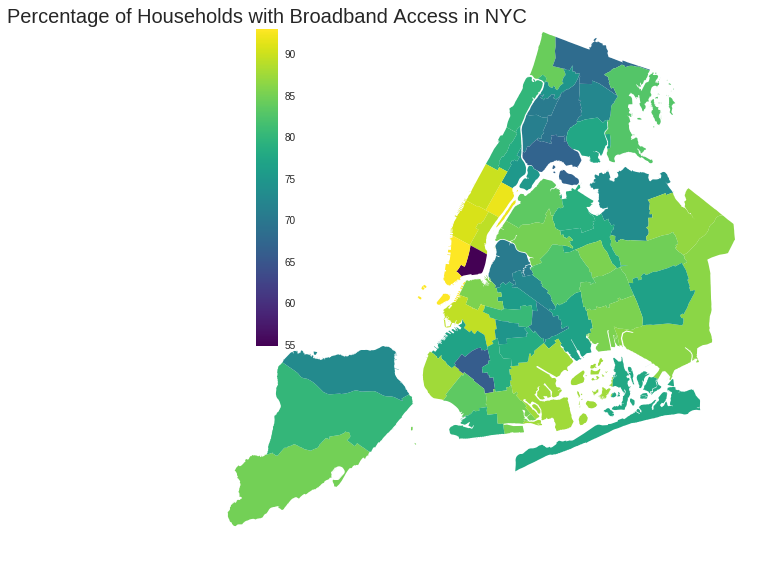

In [27]:
fig = pl.figure(figsize = (16,12))
cp.choroplethNYC(pumaBBshp, column = 'pcBB', cmap = 'viridis', 
                 edgecolor = None, lw = 2)
pl.title('Percentage of Households with Broadband Access in NYC', 
        fontsize = 20, loc = 'center')

### Figure 2: Choropleth map of the percentage of households with broadband access in NYC.  

#### 4. LinkNYC: assess whether the locations of the linkNYC stations are supplying internet where it is needed.

In [28]:
linkNYC = pd.read_csv(PUIDATA + "/linkNYClocations.csv")
linkNYC.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [29]:
linkNYC.drop('Unnamed: 0', axis=1, inplace=True)
linkNYC.head()

,link_site,longitude,date_link_,latitude
0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [30]:
linkNYC.shape

(1414, 4)

In [31]:
linkNYC['geometry'] = linkNYC.apply(lambda row: Point(row["longitude"], row["latitude"]), axis=1)
linkNYC = gpd.GeoDataFrame(linkNYC, geometry = 'geometry')
linkNYC.crs = {'init': 'epsg:4326'}
linkNYC.head()

,link_site,longitude,date_link_,latitude,geometry
0,bk-01-138951,-73.942489,2017-07-01,40.701668,POINT (-73.94248859 40.70166753)
1,bk-01-109091,-73.942169,2017-07-01,40.701542,POINT (-73.9421692831 40.7015421938)
2,bk-01-143982,-73.942239,2017-07-01,40.701930,POINT (-73.94223923850001 40.7019303439)
3,bk-01-109262,-73.942918,2017-04-28,40.705060,POINT (-73.94291758 40.70506042)
4,bk-01-125268,-73.953439,2017-03-31,40.728133,POINT (-73.953439 40.728133)


### plot

(-74.283370477424796,
 -73.672229948940085,
 40.475144526077173,
 40.936503646096469)

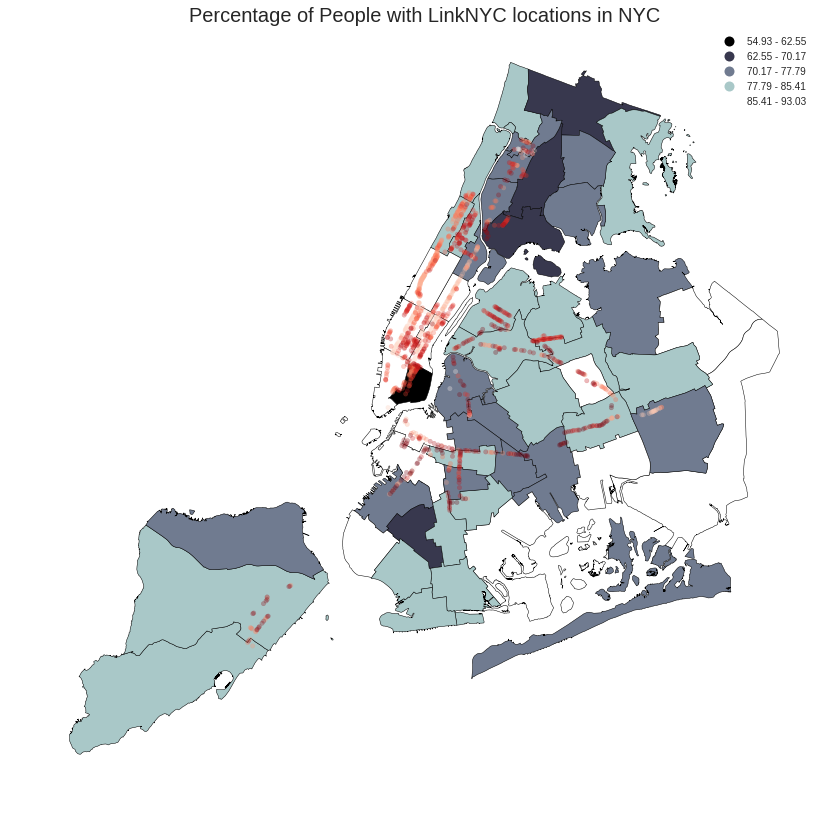

In [32]:
fig = pl.figure(figsize = (14,14))
ax = fig.add_subplot(111)

#plot the choropleth of percentage of households with broadband
pumaBBshp.plot(ax = ax, column = 'pcBB',scheme='equal_interval',
               k = 5, cmap = 'bone', edgecolor = 'black', lw = 0.5,
              legend = True)

#plot the linkNYC stations

linkNYC.plot(ax = ax, c = linkNYC['date_link_'], cmap = 'Reds', 
             alpha = 0.3, markersize = 20)

plt.title('Percentage of People with LinkNYC locations in NYC', 
          fontsize = 20)


ax.axis('off')

#### Figure 3:  Choropleth map of the percentage of households with LinkNYC locations in NYC, and the locations of linkNYC stations

### 5 Find the number of linkNYC locations per person by PUMA

##### 5.1 with the AFF API from ACS get the total population by puma and merge it into your GeoDF

In [33]:
keyPOP = 'B00001_001E'
aff1y['variables'][keyPOP]

{'attributes': 'B00001_001EA',
 'concept': 'UNWEIGHTED SAMPLE COUNT OF THE POPULATION',
 'group': 'B00001',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

In [34]:
# getting the ACS total population
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyPOP +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPop = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaPop.head()

,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
0,3075,"St. Lawrence County PUMA, New York",36,100,NaN
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,2736,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [35]:
#drop Unnamed: 4 from pumaPop

pumaPop.drop(['Unnamed: 4'], axis = 1, inplace = True)
pumaPop.head()

,B00001_001E,NAME,state,public use microdata area
0,3075,"St. Lawrence County PUMA, New York",36,100
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200
2,2736,"Warren & Washington Counties PUMA, New York",36,300
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402


In [36]:
pumaBBshp.head()

,puma,shape_leng,shape_area,geometry,B28002_004E,NAME,state,public use microdata area,B28002_001E,pcBB
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,42158,84.275820
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...,34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,49817,68.310015
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,44329,82.826141
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,44476,72.553737
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...,40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,58706,69.425612


In [37]:
# merge with the shp geodataframe

pumaPopshp = pumashp.merge(pumaPop, left_on = 'puma', 
                           right_on = 'public use microdata area')
pumaPopshp.head()

,puma,shape_leng,shape_area,geometry,B00001_001E,NAME,state,public use microdata area
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...,1959,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...,1305,"NYC-Bronx Community District 10--Co-op City, P...",36,3703
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,...",1882,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...,2011,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705


##### 5.2 find the number of station per 100 people per PUMA

In [38]:
#convert to crs

pumaPopshp.to_crs(epsg = 2263, inplace = True)
linkNYC.to_crs(epsg = 2263, inplace = True)

In [39]:
linkpp = gpd.sjoin(pumaPopshp, linkNYC, how = 'left').groupby('puma')['link_site'].count().reset_index()
linkpp.head(8)

,puma,link_site
0,3701,1
1,3702,0
2,3703,0
3,3704,0
4,3705,1
5,3706,20
6,3707,29
7,3708,19


In [40]:
pumashplc = pumaPopshp.merge(linkpp, on = 'puma')
pumashplc.head()

,puma,shape_leng,shape_area,geometry,B00001_001E,NAME,state,public use microdata area,link_site
0,3701,53227.144376,9.792852e+07,"POLYGON ((1012885.033996583 268830.4841918442,...",1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,1
1,3702,106050.008344,1.889860e+08,"POLYGON ((1021632.335632326 267934.4393920284,...",1959,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,0
2,3703,304875.033427,2.670770e+08,(POLYGON ((1042822.450195312 243439.8142089319...,1305,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,0
3,3704,47970.900868,1.062129e+08,"POLYGON ((1026308.769592285 256767.6972045382,...",1882,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,0
4,3705,68593.066759,1.224946e+08,"POLYGON ((1020080.524597168 255041.8771972096,...",2011,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,1


In [41]:
#linkNYC per 100 inhabitants

pumashplc['linkNYCp100p'] = (pumashplc['link_site'] / 
                             pumashplc['B00001_001E']) * 100
pumashplc["linkNYCp100p"].describe()

count    55.000000
mean      1.565892
std       2.933074
min       0.000000
25%       0.000000
50%       0.538358
75%       1.646966
max      15.141540
Name: linkNYCp100p, dtype: float64

##### at last, plot the linkNYC locations on top of a choropleth of number of stations per 100 people in 10 equal intervals

(905464.7392303485, 1075092.8783844009, 112485.76061615368, 280480.41464392253)

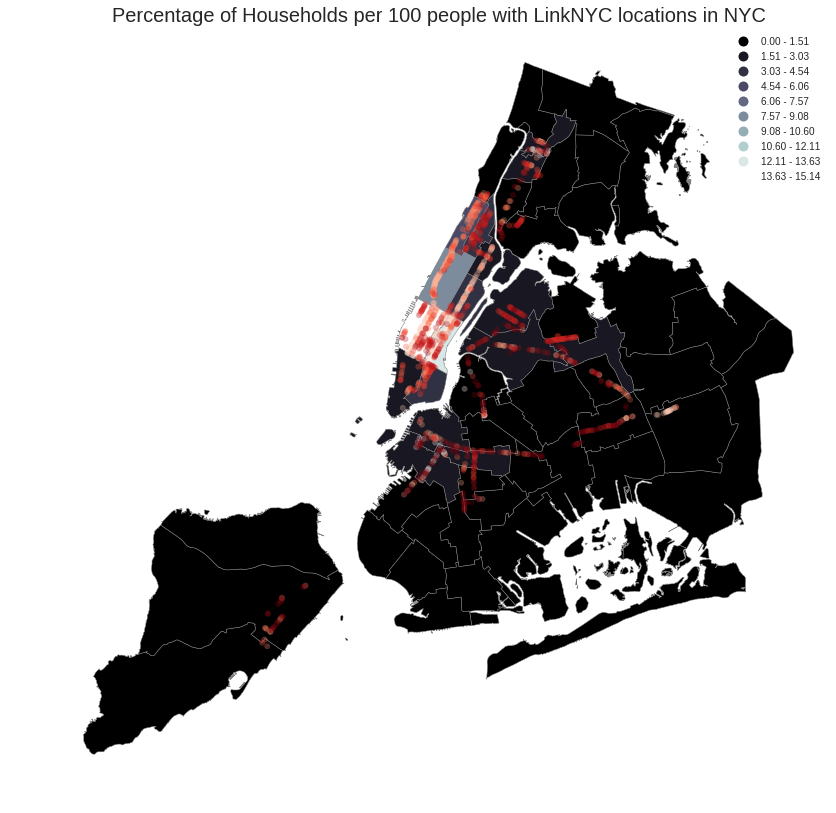

In [42]:
fig = pl.figure(figsize = (14,14))
ax = fig.add_subplot(111)

#plot the choropleth of percentage of households with broadband
pumashplc.plot(ax = ax, column = 'linkNYCp100p',scheme='equal_interval',
               k = 10, cmap = 'bone', edgecolor = 'grey', lw = 0.5,
              legend = True)

#plot the linkNYC stations

linkNYC.plot(ax = ax, c = linkNYC['date_link_'], cmap = 'Reds', 
             alpha = 0.3, markersize = 30)

plt.title('Percentage of Households per 100 people with LinkNYC locations in NYC', 
          fontsize = 20)


ax.axis('off')

#### Figure 4:  Choropleth map of the percentage of households with LinkNYC locations in NYC per 100 people, and the locations of linkNYC stations

### Extra Credit 1:

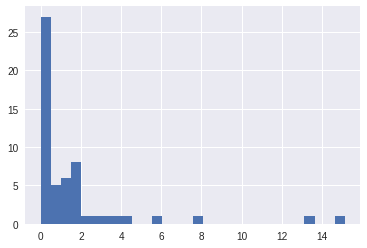

In [44]:
pl.hist(pumashplc["linkNYCp100p"], bins=30);

##### To enhance visibility, I would change the color scheme in order to better see the lower numbers.

### Extra Credit 2: